In [2]:
import os
os.chdir('../')  # Moving up one directory to the root
import sys
import tensorflow as tf
import numpy as np
import random
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from models.sentiment_model import EnhancedDistilBertForSentiment
from config.model_config import ModelConfig
from main import SentimentAnalyzer
from utils.analysis import SentimentAnalysisVisualizer

2024-12-06 13:41:17.590909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Add project root to Python path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

In [4]:
# Initialize analyzer and load model
analyzer = SentimentAnalyzer()
model, history = analyzer.load_saved_model(epoch=5)

print("Processing data to get test split...")
analyzer.process_data()

Loading model from directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Processing data to get test split...
Training set size: 4200 (70.0%)
Validation set size: 1200 (20.0%)
Test set size: 600 (10.0%)


(array(['I WANT to give it four stars, but we had a problem at the end.\\n\\nWe ALWAYS go to Toby Keith\'s - the \\"She\'s a hottie wrap\\" is off the charts DELISH. the drinks are huge and the waiter we had - Alfonso, was amazing! No complaints on food or service, but my brother had a Groupon that he showed to the guy in the beginning, and he redeemed it and everything, but he still got charged full price in the end.\\n\\nWe will still come back tho - it is a staple every Vegas trip!!!!',
        "A beauty supply staple in the Charlotte area for years and years, Tisun has delivered a huge selection of products ranging from wigs, hair care lines from a to z, weave, hair accessories, and even has a hair salon in the back...........I'm talking full service.  They carry my favorite brand of african soap and the largest selection I've seen of Miss Jessie's hair care products.  It's located in the shady strip mall off of North Tryon, but don't mind that as I can almost guarantee you they ha

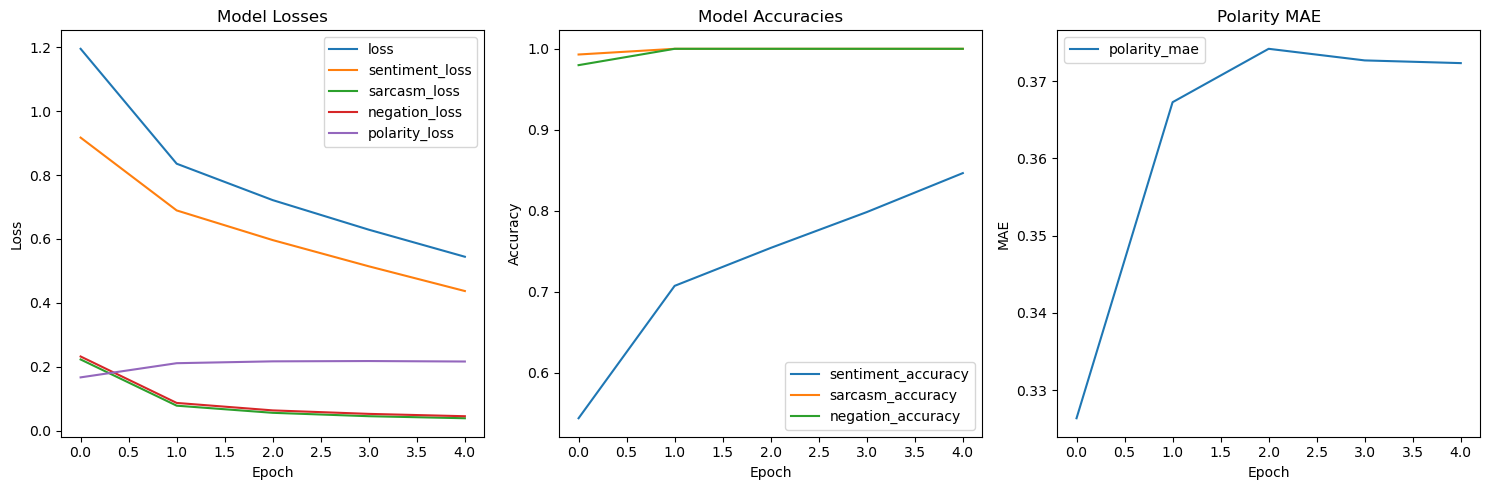


Final Training Metrics:
loss: 0.5443
negation_loss: 0.0454
polarity_loss: 0.2166
sarcasm_loss: 0.0391
sentiment_loss: 0.4371
negation_accuracy: 1.0000
polarity_mae: 0.3723
sarcasm_accuracy: 1.0000
sentiment_accuracy: 0.8465
val_loss: 0.7097
val_negation_loss: 0.0377
val_polarity_loss: 0.0398
val_sarcasm_loss: 0.0312
val_sentiment_loss: 0.6633
val_negation_accuracy: 1.0000
val_polarity_mae: 0.1623
val_sarcasm_accuracy: 1.0000
val_sentiment_accuracy: 0.7317
lr: 0.0000


In [5]:
# Visualize training history
visualizer = SentimentAnalysisVisualizer()
visualizer.visualize_training_history(history)

In [6]:
print("\nEvaluating model on test set...")
test_predictions = []
print(f"Processing {len(analyzer.test_texts)} test examples...")

for i, text in enumerate(analyzer.test_texts):
    prediction = analyzer.predict(text)
    test_predictions.append(prediction)
    if (i + 1) % 100 == 0:  # Progress update every 100 examples
        print(f"Processed {i + 1}/{len(analyzer.test_texts)} examples")


Evaluating model on test set...
Processing 600 test examples...
Processed 100/600 examples
Processed 200/600 examples
Processed 300/600 examples
Processed 400/600 examples
Processed 500/600 examples
Processed 600/600 examples


In [7]:
# First, let's check what format our test labels are in
print("Test labels shape:", analyzer.test_labels['sentiment'].shape)
print("Sample test label:", analyzer.test_labels['sentiment'][0])

Test labels shape: (600,)
Sample test label: 0



Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.70      0.77       200
     Neutral       0.59      0.70      0.64       200
    Positive       0.78      0.76      0.77       200

    accuracy                           0.72       600
   macro avg       0.74      0.72      0.73       600
weighted avg       0.74      0.72      0.73       600



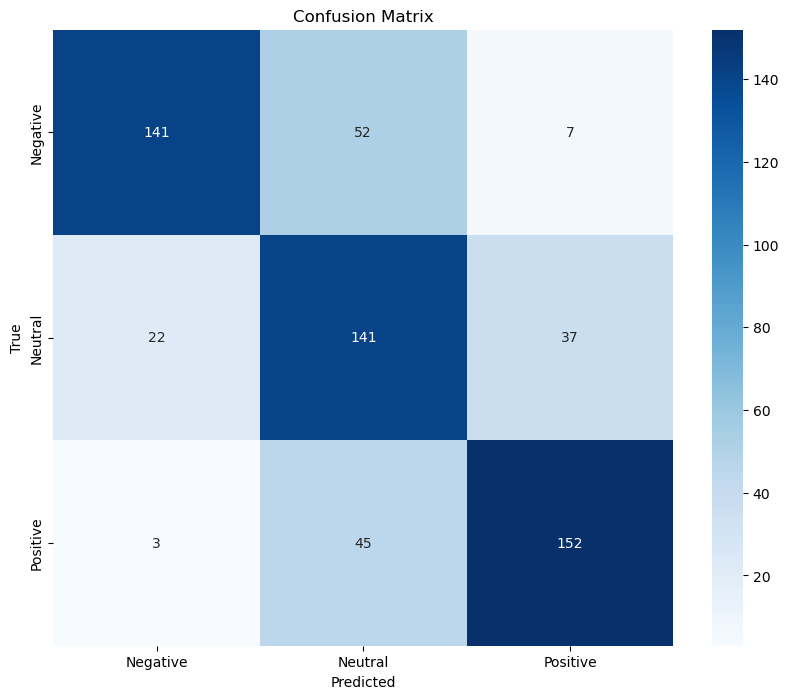


Detailed Examples from Test Set:

Text: This is honestly the best time I have had in Vegas by far! If you are looking for a fantastic pool party then look no further than the (in)famous Wet Republic at MGM!\nMy tip for this place? Either prepay tickets, get on the guest list, win the lottery and buy bottle service or turn up early.\n\nMy partner, his friend and I first tried to get in on Friday 4th July to see Afrojack play and the line was absolutely ridiculous! We got told the club was at capacity and would have to wait 5 hours for even a chance of getting in. Wet Republic opens at 11am and we got there around 1/1.30pm so we decided to try again on Sunday 6th to see Tiesto.\nThe next time was perfect! We arrived at 10.45am (we stayed at MGM so we were allowed to access the pool early), queued up and got in with minimal wait time and no issues. We found a little spot on the side of the pool and we stayed there all day, taking it in turns to mind our belongings. It got absolutely CRAZ

In [8]:
# 4. Calculate metrics - note that y_true is already in correct format
y_true = analyzer.test_labels['sentiment']  # Already integers (0, 1, 2)
y_pred = [np.argmax([p['sentiment']['negative'], p['sentiment']['neutral'], p['sentiment']['positive']]) 
          for p in test_predictions]

# 5. Display metrics
target_names = ['Negative', 'Neutral', 'Positive']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 6. Show confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 7. Show detailed examples
print("\nDetailed Examples from Test Set:")
sample_indices = random.sample(range(len(analyzer.test_texts)), 5)
for idx in sample_indices:
    text = analyzer.test_texts[idx]
    true_sentiment = analyzer.test_labels['sentiment'][idx]
    pred = test_predictions[idx]
    
    print(f"\nText: {text}")
    print(f"True Sentiment: {target_names[true_sentiment]}")
    print(f"Predicted probabilities:")
    print(f"- Negative: {pred['sentiment']['negative']:.3f}")
    print(f"- Neutral:  {pred['sentiment']['neutral']:.3f}")
    print(f"- Positive: {pred['sentiment']['positive']:.3f}")
    print(f"Additional features:")
    print(f"- Sarcasm detected: {pred['sarcasm']['detected']}")
    print(f"- Negation detected: {pred['negation']['detected']}")
    print(f"- Multipolar: {pred['multipolarity']['is_multipolar']}")


Feature Distribution in Test Set:

Sarcasm Detection:
True:  0 (0.0%)
False: 600 (100.0%)

Negation Detection:
True:  0 (0.0%)
False: 600 (100.0%)

Multipolarity Detection:
True:  92 (15.3%)
False: 508 (84.7%)

Detailed Feature Analysis:

Sarcasm Probabilities:
Min: 0.506
Max: 0.556
Mean: 0.508

Negation Probabilities:
Min: 0.508
Max: 0.561
Mean: 0.511

Multipolarity Scores:
Min: 0.305
Max: 0.816
Mean: 0.605

Special Tokens Found:
_SARC_ tokens: 0
_NEG_ tokens: 0


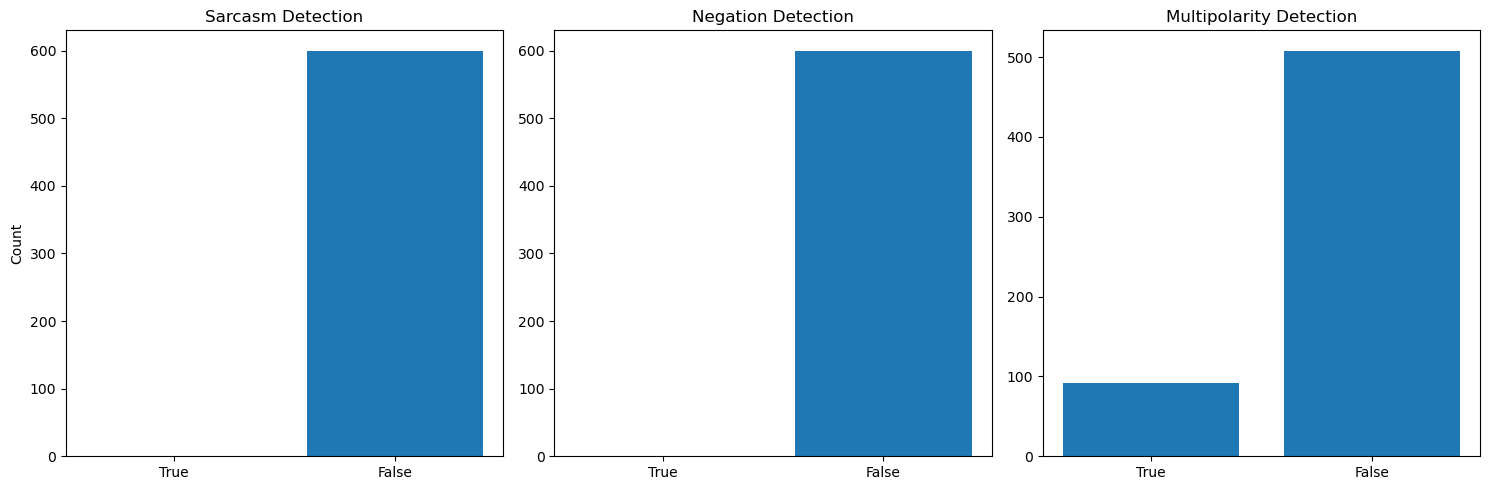

In [9]:
# 1. First get the basic counts
sarcasm_counts = {
    'True': sum(1 for p in test_predictions if p['sarcasm']['detected']),
    'False': sum(1 for p in test_predictions if not p['sarcasm']['detected'])
}

negation_counts = {
    'True': sum(1 for p in test_predictions if p['negation']['detected']),
    'False': sum(1 for p in test_predictions if not p['negation']['detected'])
}

multipolar_counts = {
    'True': sum(1 for p in test_predictions if p['multipolarity']['is_multipolar']),
    'False': sum(1 for p in test_predictions if not p['multipolarity']['is_multipolar'])
}

# Display counts and percentages
total = len(test_predictions)

print("\nFeature Distribution in Test Set:")
print("\nSarcasm Detection:")
print(f"True:  {sarcasm_counts['True']} ({sarcasm_counts['True']/total*100:.1f}%)")
print(f"False: {sarcasm_counts['False']} ({sarcasm_counts['False']/total*100:.1f}%)")

print("\nNegation Detection:")
print(f"True:  {negation_counts['True']} ({negation_counts['True']/total*100:.1f}%)")
print(f"False: {negation_counts['False']} ({negation_counts['False']/total*100:.1f}%)")

print("\nMultipolarity Detection:")
print(f"True:  {multipolar_counts['True']} ({multipolar_counts['True']/total*100:.1f}%)")
print(f"False: {multipolar_counts['False']} ({multipolar_counts['False']/total*100:.1f}%)")

# 2. Then add the detailed probability analysis
print("\nDetailed Feature Analysis:")
print("\nSarcasm Probabilities:")
sarcasm_probs = [p['sarcasm']['probability'] for p in test_predictions]
print(f"Min: {min(sarcasm_probs):.3f}")
print(f"Max: {max(sarcasm_probs):.3f}")
print(f"Mean: {np.mean(sarcasm_probs):.3f}")

print("\nNegation Probabilities:")
negation_probs = [p['negation']['probability'] for p in test_predictions]
print(f"Min: {min(negation_probs):.3f}")
print(f"Max: {max(negation_probs):.3f}")
print(f"Mean: {np.mean(negation_probs):.3f}")

print("\nMultipolarity Scores:")
polarity_scores = [p['multipolarity']['score'] for p in test_predictions]
print(f"Min: {min(polarity_scores):.3f}")
print(f"Max: {max(polarity_scores):.3f}")
print(f"Mean: {np.mean(polarity_scores):.3f}")

# Check for special tokens in processed texts
special_tokens = {
    'SARC': sum(1 for idx, p in enumerate(test_predictions) if '_SARC_' in analyzer.test_texts[idx]),
    'NEG': sum(1 for idx, p in enumerate(test_predictions) if '_NEG_' in analyzer.test_texts[idx])
}
print("\nSpecial Tokens Found:")
print(f"_SARC_ tokens: {special_tokens['SARC']}")
print(f"_NEG_ tokens: {special_tokens['NEG']}")

# 3. Keep your visualization code if you want it
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Sarcasm plot
ax1.bar(['True', 'False'], [sarcasm_counts['True'], sarcasm_counts['False']])
ax1.set_title('Sarcasm Detection')
ax1.set_ylabel('Count')

# Negation plot
ax2.bar(['True', 'False'], [negation_counts['True'], negation_counts['False']])
ax2.set_title('Negation Detection')

# Multipolarity plot
ax3.bar(['True', 'False'], [multipolar_counts['True'], multipolar_counts['False']])
ax3.set_title('Multipolarity Detection')

plt.tight_layout()
plt.show()